# Summarize performance of different backend applications

Possible options:
* Local server - running locally with `make run` on same machine as tests.
* Docker server - running locally with `make docker-run` on same machine as tests.


## How performance measurments are done

Run two terminal on testing machine.

In terminal 1 run backend server:
```bash
# cd to backend app folder, example:
cd ~/prj/vscar/back/vscar-back-fastapi/

# for local server
make run
# for docker server
make docker-run
```

In terminal 2 run performance tests:
```bash
cd ~/prj/vscar/tests/
# use run-perf-back-% target, example:
make run-perf-back-fastapi
```

Repeat for other apps

This will put csv files with measurments into `perf_test/data` folder.
If both local and docker results are needed:
* run first time for local then move manually csv files from `perf_test/data/*.csv` to `perf_test/data/local/*.csv`
* run second time for docker then move manually csv files from `perf_test/data/*.csv` to `perf_test/data/docker/*.csv`

After that run this notebook.

### Build all backend docker images

Run:
```bash
make images-build
```

Backend docker images:
```bash
make images-show
docker images | grep "REPOSITORY\|vscar-back" | sort -k7 -h
REPOSITORY                                 TAG                        IMAGE ID       CREATED        SIZE
vscar-back-gin-app                         latest                     5933ec5524e5   2 hours ago    94.6MB
vscar-back-rocket-app                      latest                     d40bcf699b46   35 hours ago   96.8MB
vscar-back-fastapi-app                     latest                     6916df15dfe2   2 hours ago    180MB
vscar-back-ktor-app                        latest                     9490a90968ad   55 years ago   228MB
vscar-back-spring-app                      latest                     f1aa90837daa   45 years ago   274MB
vscar-back-nestjs-app                      latest                     ba870039db6a   28 hours ago   443MB
```


In [ ]:
from pathlib import Path

import pandas as pd
import seaborn as sns

folder = Path("data/")
assert folder.exists() and folder.is_dir()  # noqa: PT018, S101
csvs = list(folder.glob("**/vscar*.csv"))

dfs = []
for csv in csvs:
    df_csv = pd.read_csv(csv)
    if csv.parent.name != "data":
        df_csv["server"] = csv.parent.name
    dfs.append(df_csv)

df = pd.concat(dfs)

df.head()

,Unnamed: 0,test_type,app,exec_time,response_code,request_data,parallel,server
0,0,loop_through_pages,vscar-back-rocket,241.88,200,"{'page': 1, 'limit': 100, 'text': '', 'attribu...",False,docker
1,1,loop_through_pages,vscar-back-rocket,198.02,200,"{'page': 2, 'limit': 100, 'text': '', 'attribu...",False,docker
2,2,loop_through_pages,vscar-back-rocket,249.04,200,"{'page': 3, 'limit': 100, 'text': '', 'attribu...",False,docker
3,3,loop_through_pages,vscar-back-rocket,250.15,200,"{'page': 4, 'limit': 100, 'text': '', 'attribu...",False,docker
4,4,loop_through_pages,vscar-back-rocket,198.18,200,"{'page': 5, 'limit': 100, 'text': '', 'attribu...",False,docker


# Check for code responses

In [68]:
df["response_code"].unique()

array([200, 201])

In [69]:
df_avg = df.groupby(["test_type", "app", "parallel", "server"])["exec_time"].mean().reset_index()
df_avg.head()

,test_type,app,parallel,server,exec_time
0,loop_through_pages,vscar-back-fastapi,False,docker,3434.669667
1,loop_through_pages,vscar-back-fastapi,False,local,3417.113833
2,loop_through_pages,vscar-back-fastapi,True,docker,43390.530500
3,loop_through_pages,vscar-back-fastapi,True,local,46085.487833
4,loop_through_pages,vscar-back-gin,False,docker,168.824500


In [ ]:
def plot_and_print(test_type: str, *, parallel: bool) -> None:
    """Plot and pring data."""
    df_tt = df_avg[(df_avg["test_type"] == test_type) & (df_avg["parallel"] == parallel)]

    g = sns.FacetGrid(df_tt, col="server", margin_titles=True, height=3.5, aspect=1.2)

    g.map_dataframe(sns.barplot, x="app", y="exec_time", palette="rainbow", hue="app")
    g.set_xticklabels(rotation=45)

    print(f"\nData for '{test_type}' Test Type:\n")  # noqa: T201
    print(df_tt.sort_values(["server", "app"]).to_string(index=False))  # noqa: T201

## Base on loop_through_pages


Data for 'loop_through_pages' Test Type:

         test_type                app  parallel server   exec_time
loop_through_pages vscar-back-fastapi     False docker 3434.669667
loop_through_pages     vscar-back-gin     False docker  168.824500
loop_through_pages    vscar-back-ktor     False docker  159.709333
loop_through_pages  vscar-back-nestjs     False docker  151.079333
loop_through_pages  vscar-back-rocket     False docker  173.556333
loop_through_pages  vscar-back-spring     False docker  144.300667
loop_through_pages vscar-back-fastapi     False  local 3417.113833
loop_through_pages     vscar-back-gin     False  local  158.889833
loop_through_pages    vscar-back-ktor     False  local  159.512667
loop_through_pages  vscar-back-nestjs     False  local  149.769000
loop_through_pages  vscar-back-rocket     False  local  178.992500
loop_through_pages  vscar-back-spring     False  local  222.471667


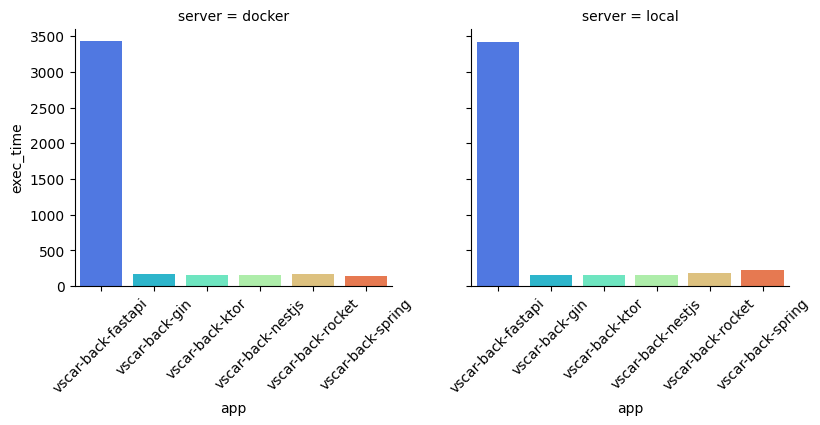

In [71]:
plot_and_print("loop_through_pages", parallel=False)


Data for 'loop_through_pages' Test Type:

         test_type                app  parallel server    exec_time
loop_through_pages vscar-back-fastapi      True docker 43390.530500
loop_through_pages     vscar-back-gin      True docker   423.548833
loop_through_pages    vscar-back-ktor      True docker   400.581667
loop_through_pages  vscar-back-nestjs      True docker   683.822667
loop_through_pages  vscar-back-rocket      True docker   470.325667
loop_through_pages  vscar-back-spring      True docker   558.844667
loop_through_pages vscar-back-fastapi      True  local 46085.487833
loop_through_pages     vscar-back-gin      True  local   310.701000
loop_through_pages    vscar-back-ktor      True  local   287.070667
loop_through_pages  vscar-back-nestjs      True  local   634.813667
loop_through_pages  vscar-back-rocket      True  local   353.067500
loop_through_pages  vscar-back-spring      True  local   493.277833


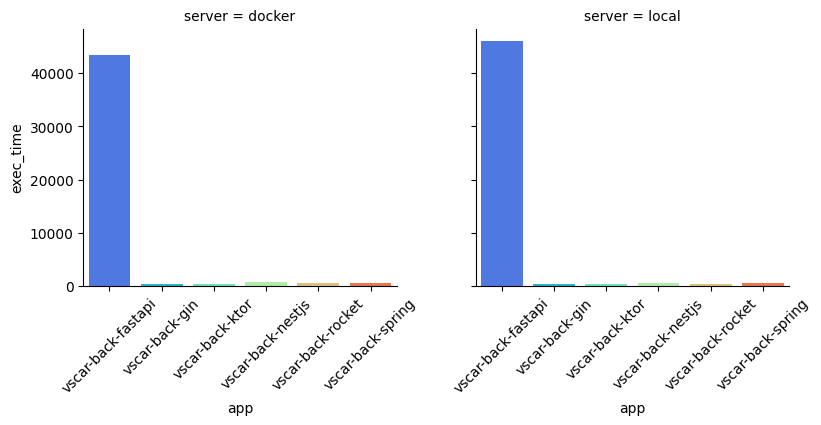

In [72]:
plot_and_print("loop_through_pages", parallel=True)

## Base on price_in_steps


Data for 'price_in_steps' Test Type:

     test_type                app  parallel server  exec_time
price_in_steps vscar-back-fastapi     False docker  43.931710
price_in_steps     vscar-back-gin     False docker  12.014941
price_in_steps    vscar-back-ktor     False docker  10.211354
price_in_steps  vscar-back-nestjs     False docker  10.822684
price_in_steps  vscar-back-rocket     False docker  10.586556
price_in_steps  vscar-back-spring     False docker   9.888219
price_in_steps vscar-back-fastapi     False  local  40.591116
price_in_steps     vscar-back-gin     False  local  13.290404
price_in_steps    vscar-back-ktor     False  local   8.308765
price_in_steps  vscar-back-nestjs     False  local   9.671995
price_in_steps  vscar-back-rocket     False  local  12.534442
price_in_steps  vscar-back-spring     False  local  19.527173


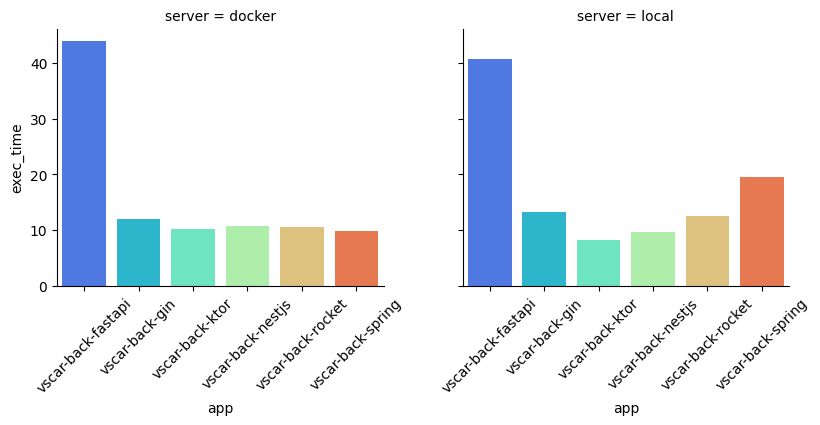

In [73]:
plot_and_print("price_in_steps", parallel=False)


Data for 'price_in_steps' Test Type:

     test_type                app  parallel server  exec_time
price_in_steps vscar-back-fastapi      True docker 141.034181
price_in_steps     vscar-back-gin      True docker  61.160214
price_in_steps    vscar-back-ktor      True docker  36.577957
price_in_steps  vscar-back-nestjs      True docker  94.988171
price_in_steps  vscar-back-rocket      True docker  44.047767
price_in_steps  vscar-back-spring      True docker  59.074679
price_in_steps vscar-back-fastapi      True  local 115.582114
price_in_steps     vscar-back-gin      True  local  24.149145
price_in_steps    vscar-back-ktor      True  local  15.930689
price_in_steps  vscar-back-nestjs      True  local  63.783872
price_in_steps  vscar-back-rocket      True  local  28.198907
price_in_steps  vscar-back-spring      True  local  41.107150


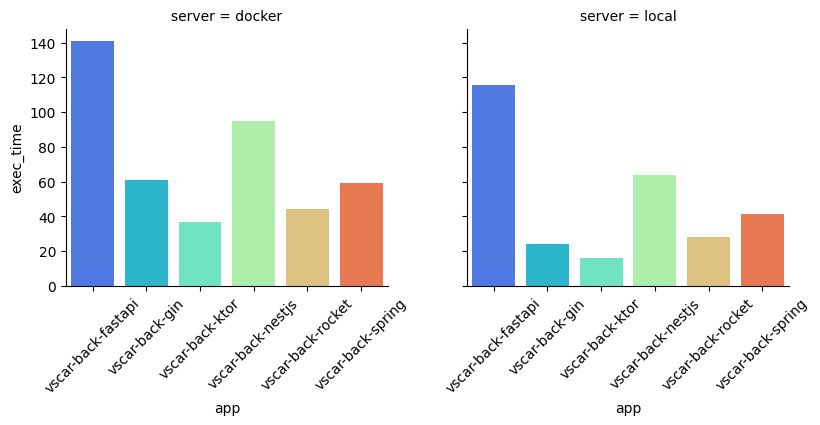

In [74]:
plot_and_print("price_in_steps", parallel=True)